#  Analysis code for mVEP BCI EEG sensor domain analysis 

### Written by Joshua Kosnoff except where otherwise noted.

## Load in Preprocessed Data

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mne
import numpy as np
import pandas as pd

my_df = pd.read_pickle("Analysis_Rerun.pkl")

In [2]:
print("Total N: ", len(np.unique(my_df.subject)))
print("tFUS-GC N: ", len(np.unique(my_df["subject"].loc[my_df.condition == "tFUS-GC"])))
print("tFUS-CP N: ", len(np.unique(my_df["subject"].loc[my_df.condition == "tFUS-GP"])))
print("Non-Modulated N: ", len(np.unique(my_df["subject"].loc[my_df.condition == "Non-Modulated"])))
print("Decoupled-Sham N: ", len(np.unique(my_df["subject"].loc[my_df.condition == "Decoupled-Sham"])))

Total N:  25
tFUS-GC N:  25
tFUS-CP N:  17
Non-Modulated N:  24
Decoupled-Sham N:  19


In [3]:
# Silence mne logs
mne.set_log_level('CRITICAL')

def normalize_channel_nomenclature(data_epoch, montage = "easycap-M1"):
    
    try:
        data_epoch.set_montage(montage, match_case=True)
    except ValueError as e:
        data_epoch.rename_channels({"FP1": "Fp1", "FP2": "Fp2", "FPz": "Fpz"}).set_montage(montage, match_case = True)
    
    return data_epoch

# Step 1: Normalize the channel nomenclature
my_df["data_epoch"] = my_df["data_epoch"].apply(lambda x: normalize_channel_nomenclature(x))

# Step 2: Find the same channels across all trials
epoch_list = my_df["data_epoch"].to_list()
all_channels = [i.ch_names for i in epoch_list]

# # Step 3: Get the overlapping channels
shared_channels = list(set.intersection(*map(set,all_channels)))

# # Step 4: Pick the shared channels
my_df["data_epoch"] = my_df["data_epoch"].apply(lambda x: x.pick_channels(shared_channels))

# Step 4: Z-Score based on baseline
my_df["data_epoch"] =  my_df["data_epoch"].apply(lambda x: x.apply_function(mne.baseline.rescale, times = x.times, baseline = (None,0), mode = 'mean'))

In [4]:
print(len(np.unique(my_df.subject)))

25


In [5]:
# Merge all same-condition epochs into the same group

tFUS_del_E = mne.concatenate_epochs(my_df["data_epoch"].loc[(my_df.condition == "tFUS-GC")].to_list(), add_offset=True)
baseline_del_E = mne.concatenate_epochs(my_df["data_epoch"].loc[(my_df.condition == "Non-Modulated")].to_list(), add_offset=True)
sham_del_E = mne.concatenate_epochs(my_df["data_epoch"].loc[(my_df.condition.isin(["Decoupled-Sham", "Decoupled-Sham-2"]))].to_list(), add_offset=True)
usc_del_E = mne.concatenate_epochs(my_df["data_epoch"].loc[(my_df.condition == "tFUS-GP")].to_list(), add_offset=True)

### Temporal Visualization (time series)

In [6]:
# Reset matplotlib
plt.style.use(['default'])

# Configure new plot settings
############# 
plt.rc('figure', dpi=300.0)

SMALL_SIZE = 20 * 1.5
MEDIUM_SIZE = 25 * 1.5
BIGGER_SIZE = 30 * 2
plt.rc('font', family='Arial', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#############    

e_L_V = ["O1", "PO3", "P1", "P3", "P5", "P7", "TP7", "PO7", "Oz", "POz", "CPz", "CP1", "CP3", "CP5", "C1", "C3", "C5", "Cz"]

delta = [1,4]
theta = [4,8]
alpha = [8, 12]
beta = [12, 30]
gamma = [30, 40]
a = [1, 40]

labels = ["ERP (1-40 Hz)", " θ (4-8 Hz) ", "α (8-12 Hz)", "β (12-30 Hz)", "γ (30-40 Hz)"]
arrs = [tFUS_del_E, sham_del_E, baseline_del_E, usc_del_E]

bands = [a, theta, alpha, beta, gamma]
offset = 0

fig, ax = plt.subplots(nrows = len(arrs), ncols = len(labels) + offset, 
                       figsize = (30,20), sharey='col')
            
for j, band in enumerate(bands):
    for i in range(len(arrs)):
        
        ax[i][j+offset].axhline(y = 0 , color = 'k', linestyle = '--')
        
        ax[i][j+offset].axvline(x = 0 , color = 'k', linestyle = '--')

        arrs[i].copy().average().filter(band[0], band[1]).apply_baseline((None,0)).plot(
            axes = ax[i][j+offset], 
            show=False, 
            picks = e_L_V)
        
        # Reformat the axes into scientific notation
#         ax[i][j+offset].ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
        
        # for some reason have to call tight_layout to get the offset
        fig.tight_layout()
        # replace "e" with "x10^"
        # sci = ax[i][j+offset].yaxis.get_offset_text().get_text().split("e")[-1]
        
        # make a little more space in the figure for the topo map
        ymin, ymax = ax[i][j+offset].get_ylim()
        ymax *= 1.5
        
        # Remove "N-Avg"
        # remove the "N_ave" annotation
        for text in list(ax[i][j+offset].texts):
            text.remove()
        
        
        
        # ax[i][j+offset].set_yticks([-2.5*10**(int(sci)), 0, 2.5*10**(int(sci))])
        # ax[i][j+offset].yaxis.get_offset_text().set_visible(False)
        
        # Don't give subplots y and x axis labels --> just use super labels
        # ax[i][j+offset].set_ylabel(f"Z-Scored Response\n(x 10$^{sci}$ a.u.)", fontsize=MEDIUM_SIZE)
        # ax[i][j+offset].set_xlabel(f"Time (s)", fontsize=MEDIUM_SIZE)
        ax[i][j+offset].set_ylabel("")
        ax[i][j+offset].set_xlabel("")
        
        # Manually set limits
        # Limits were determined based on manual inspection 
        if j == 0:
            ymin, ymax = -3.5, 4
#             ymin, ymax = -1e6, 0.75e6
        elif j == 1:
            ymin, ymax = -3, 4
#             ymin, ymax = -5e5, 5e5
        elif j == 2:
            ymin, ymax = -0.5, 0.75
#             ymin, ymax = -1.2e5, 1.2e5
        else:
            ymin, ymax = -0.2, 0.3
#             ymin, ymax = -1.2e5, 1.2e5
        
        # Shade approximate n200 and p300 waves
        ax[i][j+offset].set_ylim(ymin, ymax)
        ax[i][j+offset].fill_betweenx((ymin, ymax), 0.100, 0.250, color="gold", alpha=0.1, label = "N200")
        ax[i][j+offset].fill_betweenx((ymin, ymax), 0.251, 0.400, color="purple", alpha=0.1, label = "P300")
        
        # don't show the legend on each sub plot --> too messy // manually add it in with inkscape
        # ax[i][j+offset].legend(loc="upper right")
        
        if i == 0:
            # Only add title for first row
            ax[i][j+offset].set_title(labels[j], fontsize= BIGGER_SIZE)
        else:
             ax[i][j+offset].set_title("")
                
fig.supxlabel("Time Since Stimulus (s)", fontsize= BIGGER_SIZE)
fig.supylabel("Grand Average Response (µV)", fontsize= BIGGER_SIZE)

plt.tight_layout()
plt.savefig("ERP_Overview.svg", format = 'svg', dpi = 300.0)

####################################
# Remove the following line to see the figure in this notebook. When displaying all the figures in this notebook, 
# the file is has trouble uploading to github due to its size.
####################################
plt.close();


/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_87876/3214658271.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_87876/3214658271.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


### Spatial Visualization (topo maps)

In [7]:
# Note that we aren't using this image, but we need it to extract the colorbar information from it in order
# to present the -1 to 1 scaled colorbar on the following image

fig, ax = plt.subplots()
im,cm = mne.viz.plot_topomap(tFUS_del_E.copy().average().data[:,:].mean(axis=-1),
                               tFUS_del_E.info,  vlim = (-1, 1), show=False, axes = ax);
plt.close();

In [14]:
#############   
plt.style.use(['default'])
plt.rc('figure', dpi=300.0)
    
SMALL_SIZE = 15
MEDIUM_SIZE = 17 * 1.5
BIGGER_SIZE = 20 * 1.5

plt.rc('font', family='Arial', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#############       
            
times = [0.05, 0.175, 0.325]
averaging_durations = [0.11, 0.160, 0.160]

widths = [3] * len(times)
# widths.append(1)

fig,(ax1,ax2, ax3, ax4) = plt.subplots(nrows=4, ncols = len(times), figsize=(10,10*1.33), 
                                  gridspec_kw={'width_ratios': widths})

tFUS_del_E.copy().filter(1,40).average().plot_topomap(times = times, 
                                         average = averaging_durations,
                                         axes = ax1, 
                                         show = False, 
                                         colorbar = False,
#                                          dict(markersize=10)
                                        )


sham_del_E.copy().filter(1,40).average().plot_topomap(times = times, 
                                         average = averaging_durations, 
                                         axes = ax2, 
                                         show = False, 
                                         colorbar = False,
#                                          dict(markersize=10)
                                        )

baseline_del_E.copy().filter(1,40).average().plot_topomap(times = times, 
                                             average = averaging_durations, 
                                             axes = ax3, 
                                             show = False, 
                                             colorbar=False, 
#                                              dict(markersize=10)
                                            )

usc_del_E.copy().filter(1,40).average().plot_topomap(times = times, 
                                             average = averaging_durations, 
                                             axes = ax4, 
                                             show = False, 
                                             colorbar=False, 
#                                              dict(markersize=10)
                                            )


# For some reason I can't seem to able to get MNE's title to register 250 - 400 ms ????
# (its either 250 - 390, 250 - 410, 260 - 410, 260 - 400, or 240 - 400)
# This is likely some truncation issue within MNE's plotting code, as the averaging times are consistent for 
# the 150 ms P300 as the 150 ms N200 . . .
# rewrite the title for clarity

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax[2].set_title("0.250 - 0.400 s", fontsize = BIGGER_SIZE)
    
    # Clear the titles on subsequent topos
    if i > 0:
        ax[0].set_title("", fontsize = BIGGER_SIZE)
        ax[1].set_title("", fontsize = BIGGER_SIZE)
        ax[2].set_title("", fontsize = BIGGER_SIZE)

# Manually fiddle the position of colorbar
ax_x_start = 1.05
ax_x_width = 0.04
ax_y_start = 0.0
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_ylabel("Relative Response (a.u.)",fontsize=1.75*BIGGER_SIZE) # title on top of colorbar
plt.tight_layout()
plt.savefig("Topomaps.svg", format = 'svg', dpi = 300.0)

####################################
# Remove the following line to see the figure in this notebook. When displaying all the figures in this notebook, 
# the file is has trouble uploading to github due to its size.
####################################
plt.close();

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_87876/503617008.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


## Permutation Cluster Test

Run a permutation cluster test on the EEG data. The original code for the cluster test was part of an MNE Python 
tutorial found here: https://mne.tools/stable/auto_tutorials/stats-sensor-space/75_cluster_ftest_spatiotemporal.html. It was modified and functionalized by Joshua Kosnoff.

Please note that there are well documented weaknesses with this test. This test finds significant **clusters**, but that does not guarantee that all the points within the clusters are actually significant, just that, on average, the cluster is significant. As such, caution should be used when analyzing the result to not overstate the significance. 

In [9]:
# Define channels by groups
occipital_chans = ["O1", "PO7", "PO3", "P1", "P3", "P5", "P7", "TP7", "POz",
                   "O2", "PO4", "P2", "P4", "P6", "P8", "PO8", "Oz", "Pz", "TP8"]

L_V = ["O1", "PO3", "P1", "P3", "P5", "P7", "TP7", "PO7", "Oz", "POz", "CPz", "CP1", "CP3", "CP5", "C1", "C3", "C5", "Cz"]

R_V =  ["O2", "PO2", "PO4", "PO6", "P2", "P4", "P6", "P8", "PO8"]

# L_V = ["O1", "PO3", "P1", "P3", "P5", "PO7", "Oz", "POz", "CPz", "CP1", "CP3", "CP5", "C1", "C3", "C5", "Cz"]


In [10]:
#### Permutation cluster f-test #####
def permutation_cluster_test(epoch_list,
                             event_ids, 
                             colors = "auto",
                             alpha = 0.05, 
                             parametric=False, 
                             ci = 0.95,
                             n_permutations=10000,
                             plot_combine_method = "mean", 
                             time_frequency = False, 
                             freqs = np.arange(3, 30, 3),
                             seed = 0,
                             test_thresh = 'auto',
                             test = 'f',
                             unit = "µV",
                             scientific_notation=False,
                             bins = 1,
                             yticks = 'auto',
                             tail = 1,
                             n_jobs = 1,
                             save_fig = "",
                            ):
    """
    Run a permutation cluster test and plot the significant clusters
    
    Original code taken extensively from:
    - https://mne.tools/stable/auto_tutorials/stats-sensor-space/75_cluster_ftest_spatiotemporal.html
    
    Functionalized and edited by Joshua Kosnoff
    
    Inputs:
        epoch_list: a list of MNE Epochs for the conditions to compare
        event_ids: a list of names for each condition
        colors: optional; a dictionary of formal {"Event_id": color code}
        alpha; the alpha value for determining significance
        parametric: boolean for whether to run a parametric or non-parametric test
        n_permutations: the number of permutations to run
        plot_combine_method: 'gfp', 'mean', 'median,' or 'std'; how to visualize the sensor data. 
            Default is global field power. 
        time_frequency: boolean value for whether to consider time-frequency domain
        freqs: the frequency array to consider for time_frequency analysis
        seed: the random seed to use in order to have repeatable findings
        test: the stat test to run. Currently, on F and T-tests are supported
        bins: how many timepoints to bin (average) together for timefrequency tests. Default is no averaging.
        yticks: which yticks to mark on on the time-frequency plots. 
        
    Returns:
        None
    """
    
    # assert test.lower() in ['f', 't'], "Error! Unrecognized test! Only 't' and 'f' are currently supported"
    if (isinstance(test, str)) and (test.lower() == 'f'):
        stat_func = mne.stats.f_oneway
    elif (isinstance(test, str)) and (test.lower() == 't'):
        stat_func = mne.stats.ttest_ind_no_p
    else:
        stat_func = test
    
    # Get channel adjacencies
    adjacency, ch_names = mne.channels.find_ch_adjacency(epoch_list[0].info, ch_type='eeg')
    
    # We are running an F test, so we look at the upper tail
    # see also: https://stats.stackexchange.com/a/73993
                  
    if time_frequency:
        
        # Create a 4D matrix with 
        decim = 1
        n_cycles = freqs / freqs[0]

        epochs_power = list()
        for condition in epoch_list:
            this_tfr = mne.time_frequency.tfr_morlet(
                condition,
                freqs,
                n_cycles=n_cycles,
                decim=decim,
                average=False,
                return_itc=False,
            )
            
            if bins > 1:
                decim_tfr = this_tfr.copy().decimate(bins)
                # print("Original Shape: ", this_tfr._data.shape)
                # print("Decimated Shape: ", decim_tfr._data.shape)
                avg_data = np.stack([np.mean(this_tfr._data[:,:,:,i*bins:(i+1)*bins], axis=-1) for i in range(decim_tfr._data.shape[-1])], axis = -1)
                # print("New shape: ", avg_data.shape)
                decim_tfr._data = avg_data
                this_tfr = decim_tfr
            
            this_tfr.apply_baseline(mode="mean", baseline=(None, 0))
            epochs_power.append(this_tfr.data)
        
        # transpose again to (epochs, frequencies, times, channels)
        X = [np.transpose(x, (0, 2, 3, 1)) for x in epochs_power]

        # our data at each observation is of shape frequencies × times × channels
        adjacency = mne.stats.combine_adjacency(len(freqs), len(this_tfr.times), adjacency)
                  
        # Note that a cluster forming statistic equal to the f distribution will spit out 
        # out huge cluster. As a result, we need to pick something larger, but also kind of arbitrary
        if test_thresh == 'auto':
            test_thresh = 15
    
    else:
        # Obtain the data as a 3D matrix and transpose it such that
        # the dimensions are as expected for the cluster permutation test:
        # n_epochs × n_times × n_channels
    
        X = [i.apply_baseline(baseline=(None, 0)) for i in epoch_list]
        X = [i.get_data() for i in X]
        X = [np.transpose(x, (0, 2, 1)) for x in X]
         
        if test_thresh == 'auto':
            # For an F test we need the degrees of freedom for the numerator
            # (number of conditions - 1) and the denominator (number of observations
            # - number of conditions):
            n_conditions = len(epoch_list)
            n_observations = sum(len(i) for i in X) / len(X)
            dfn = n_conditions - 1
            dfd = n_observations - n_conditions

            # Note: we calculate 1 - alpha to get the critical value
            # on the right tail
            if test.lower() == 'f':
                test_thresh = scipy.stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
            elif test.lower() == 't':
                test_thresh = scipy.stats.t.ppf(1 - alpha, df=dfd)
                
    # run the cluster based permutation analysis
    if parametric:
        # Run the parametric cluster test
        cluster_stats = mne.stats.permutation_cluster_test(
            X,
            n_permutations=n_permutations,
            threshold=test_thresh,
            tail=tail,
            n_jobs=n_jobs,
            buffer_size=None,
            adjacency=adjacency, 
            stat_fun = stat_func,
            seed=seed,
        )
    else:
        # Run the nonparametric cluster test
        cluster_stats = mne.stats.spatio_temporal_cluster_test(
            X,
            n_permutations=n_permutations,
            threshold=test_thresh,
            tail=tail,
            n_jobs=n_jobs,
            buffer_size=None,
            stat_fun = stat_func,
            adjacency=adjacency,
            seed=seed,
        )
        
    F_obs, clusters, p_values, _ = cluster_stats
    print(p_values)
    # Accept the clusters with a p-value less than alpha
    # NOTE: remember the caveats with respect to "significant" clusters
    good_cluster_inds = np.where(p_values < alpha)[0]
    
    if not time_frequency:
        
        # organize data for plotting
        if plot_combine_method == 'gfp':
            # Note for some reason the GFP is very different if you follow the iter_evoked() method to get
            # confidence intervals
            evokeds = {cond: i.average() for (cond, i) in zip(event_ids, epoch_list)}
        else:
            evokeds = {cond: list(i.apply_baseline().iter_evoked()) for (cond, i) in zip(event_ids, epoch_list)}

        # define colors if not explitictly passed
        if colors == 'auto':
            colors = {j:f"C{i}" for i,j in enumerate(event_ids)}

        # loop over clusters
        for i_clu, clu_idx in enumerate(good_cluster_inds):
            # unpack cluster information, get unique indices
            time_inds, space_inds = np.squeeze(clusters[clu_idx])
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)

            # get topography for F stat
            f_map = F_obs[time_inds, ...].mean(axis=0)

            # get signals at the sensors contributing to the cluster
            sig_times = epoch_list[0].times[time_inds]

            # create spatial mask
            mask = np.zeros((f_map.shape[0], 1), dtype=bool)
            mask[ch_inds, :] = True

            # initialize figure
            fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

            # plot average test statistic and mark significant sensors
            f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epoch_list[0].info, tmin=0)
            f_evoked.plot_topomap(
                times=0,
                mask=mask,
                axes=ax_topo,
                cmap="Reds",
                vlim=(np.min, np.max),
                show=False,
                colorbar=False,
                mask_params=dict(markersize=10),
            )
            image = ax_topo.images[0]

            # remove the title that would otherwise say "0.000 s"
            ax_topo.set_title("")

            # create additional axes (for ERF and colorbar)
            divider = make_axes_locatable(ax_topo)

            # add axes for colorbar
            ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(image, cax=ax_colorbar)
            if isinstance(test, str) and (test.lower() == 'f'):
                ax_topo.set_xlabel(
                    "Averaged F-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )
            elif isinstance(test, str) and (test.lower() == 't'):
                 ax_topo.set_xlabel(
                    "Averaged t-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )
            else:
                 ax_topo.set_xlabel(
                    "Averaged F-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )

            # add new axis for time courses and plot time courses
            ax_signals = divider.append_axes("right", size="300%", pad=1.2)
            title = f"Data from "
            if len(ch_inds) > 1:
                title += f"{len(ch_inds)} channels"
            else:
                title += f"{epoch_list[0].ch_names[np.array(ch_inds)]}"

            time_plot = mne.viz.plot_compare_evokeds(
                evokeds,
                title=title,
                picks=ch_inds,
                axes=ax_signals,
                colors=colors,
                ci=ci,
                show=False,
                split_legend=True,
                legend = True,
                truncate_yaxis="auto",
                combine = plot_combine_method,
            )
            
            if scientific_notation:
                ax_signals.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
                # for some reason have to call tight_layout to get the offset
                fig.tight_layout()
                sci = ax_signals.yaxis.get_offset_text().get_text().split("e")[-1]
                if (bool(sci) == True) and (sci != 'fault{}$'):
                    # Frustratingly, negative exponents just lead to errors unless
                    # the slightly different dash is replaced with the minus sign
                    sci = "".join([i for i in sci.split() if i]) # sometimes there are spaces too!?
                    print("sci:",sci)
                    if (sci[0] in "0123456789".split()) or (sci[0] in [0,1,2,3,4,5,6,7,8,9]):
                        sci = int(sci)
                        ax_signals.yaxis.get_offset_text().set_visible(False)
                        ax_signals.set_ylabel(fr"{unit} (x$10^{{{sci}}}$)")
                    elif len(sci) > 1:
                        print("sci", sci, sci.split())
                        sci = sci[1:]
                        sci = -1 * int(sci)
                        ax_signals.yaxis.get_offset_text().set_visible(False)
                        ax_signals.set_ylabel(fr"{unit} (x$10^{{{sci}}}$)")
                    else:
                        ax_signals.set_ylabel(unit)
                   
                else:
                    ax_signals.set_ylabel(unit)
            else:
                ax_signals.set_ylabel(unit)

            # plot temporal cluster extent
            ymin, ymax = ax_signals.get_ylim()
            ax_signals.fill_betweenx(
                (ymin, ymax), sig_times[0], sig_times[-1], color="gray", alpha=0.3
            )
            
            # Solid white background of legend
            # ax_signals.legend(loc = 'upper left', facecolor='white', framealpha=0.95).set_zorder(np.inf)
            ax_signals.legend(loc='upper left', bbox_to_anchor=(1, 1), facecolor='white', framealpha=0.95).set_zorder(np.inf)

            # clean up viz
            mne.viz.tight_layout(fig=fig)
            fig.subplots_adjust(bottom=0.05)
            
            if save_fig:
                save_fig_left = save_fig.split(".")[0] + fr"-{i_clu}"
                save_fig = save_fig_left + "." + save_fig.split(".")[1]
                plt.savefig(save_fig, format = save_fig.split(".")[-1], dpi=300)
            
            
            plt.show()
        
        
    else:  
        for i_clu, clu_idx in enumerate(good_cluster_inds):
            # unpack cluster information, get unique indices
            freq_inds, time_inds, space_inds = clusters[clu_idx]
            ch_inds = np.unique(space_inds)
            time_inds = np.unique(time_inds)
            freq_inds = np.unique(freq_inds)

            # get topography for F stat
            f_map = F_obs[freq_inds].mean(axis=0)
            f_map = f_map[time_inds].mean(axis=0)

            # get signals at the sensors contributing to the cluster
            # sig_times = epoch_list[0].times[time_inds]
            # Call times from tfr instead of epoch in case of binning
            sig_times = this_tfr.times[time_inds]

            # initialize figure
            fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

            # create spatial mask
            mask = np.zeros((f_map.shape[0], 1), dtype=bool)
            mask[ch_inds, :] = True

            # plot average test statistic and mark significant sensors
            f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epoch_list[0].info, tmin=0)
            f_evoked.plot_topomap(
                times=0,
                mask=mask,
                axes=ax_topo,
                cmap="Reds",
                vlim=(np.min, np.max),
                show=False,
                colorbar=False,
                mask_params=dict(markersize=10),
            )
            image = ax_topo.images[0]
            
            # create additional axes (for ERF and colorbar)
            divider = make_axes_locatable(ax_topo)

            # add axes for colorbar
            ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(image, cax=ax_colorbar)
            if isinstance(test, str) and (test.lower() == 'f'):
                ax_topo.set_xlabel(
                    "Averaged F-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )
            elif isinstance(test, str) and (test.lower() == 't'):
                 ax_topo.set_xlabel(
                    "Averaged t-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )
            else:
                 ax_topo.set_xlabel(
                    "Averaged F-map \n({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
                )


            # remove the title that would otherwise say "0.000 s"
            ax_topo.set_title("")

            # add new axis for spectrogram
            ax_spec = divider.append_axes("right", size="300%", pad=1.2)
            title = f"Spectrogram of "
            if len(ch_inds) > 1:
                title += f"{len(ch_inds)} channels (max over channels)"
            else:
                print(ch_inds)
                title += f"{np.array(epoch_list[0].ch_names)[np.array(ch_inds, dtype = int)][0]}"
                
            F_obs_plot = F_obs[..., ch_inds].max(axis=-1)
            F_obs_plot_sig = np.zeros(F_obs_plot.shape) * np.nan
            F_obs_plot_sig[tuple(np.meshgrid(freq_inds, time_inds))] = F_obs_plot[
                tuple(np.meshgrid(freq_inds, time_inds))
            ]

            for f_image, cmap, interp in zip([F_obs_plot, F_obs_plot_sig], ["gray", "Wistia"], ['gaussian', None]):
                c = ax_spec.imshow(
                    f_image,
                    cmap=cmap,
                    aspect="auto",
                    origin="lower",
                    extent=[epoch_list[0].times[0], epoch_list[0].times[-1], freqs[0], freqs[-1]],
                    interpolation = interp, # smooth the gray background
                )
            
            
            # print("y lim: ", ax_spec.get_ylim())
            if not isinstance(yticks, str):
                ax_spec.set_yticks(yticks)
            
            ax_spec.set_xlabel("Time (ms)")
            ax_spec.set_ylabel("Frequency (Hz)")
            ax_spec.set_title(title)

            # add another colorbar
            ax_colorbar2 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(c, cax=ax_colorbar2)
            ax_colorbar2.set_ylabel("F-stat")

            # clean up viz
            mne.viz.tight_layout(fig=fig)
            fig.subplots_adjust(bottom=0.05)
            
            if save_fig:
                save_fig_left = save_fig.split(".")[0] + fr"-{i_clu}"
                save_fig = save_fig_left + "." + save_fig.split(".")[1]
                plt.savefig(save_fig, format = save_fig.split(".")[-1], dpi=300)
            
            plt.show()
        
    return

In [11]:
# Load data
my_df = pd.read_pickle("Analysis_Rerun.pkl")

# Step 1: Normalize the channel nomenclature
my_df["data_epoch"] = my_df["data_epoch"].apply(lambda x: normalize_channel_nomenclature(x))

# Step 2: Find the same channels across all trials
epoch_list = my_df["data_epoch"].to_list()
all_channels = [i.ch_names for i in epoch_list]

# Step 3: Get the overlapping channels
shared_channels = list(set.intersection(*map(set,all_channels)))

# Step 4: Pick the shared channels
my_df["data_epoch"] = my_df["data_epoch"].apply(lambda x: x.pick_channels(shared_channels))

# Initialize empty lists for each condition
tFUSs = []
baselines = []
shams = []
uscs = []

conditions = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]
lists = [baselines, tFUSs, shams, uscs]
n_subjects = 0

for subject in np.unique(my_df.subject):
    subj_df = my_df.loc[my_df.subject == subject]
    
    if len(np.unique(subj_df.condition)) == 4:
        n_subjects = n_subjects + 1
        for i, condition in enumerate(conditions):
            evoked = mne.concatenate_epochs(subj_df["data_epoch"].loc[(subj_df.condition == condition)].to_list(), add_offset=True)
            lists[i].append(evoked)


# Equal number of trials per subject
mne.epochs.equalize_epoch_counts(tFUSs, method='mintime')      
mne.epochs.equalize_epoch_counts(baselines, method='mintime')   
mne.epochs.equalize_epoch_counts(shams, method='mintime')      
mne.epochs.equalize_epoch_counts(uscs, method='mintime')   
                
tFUSs = mne.concatenate_epochs(tFUSs)
baselines = mne.concatenate_epochs(baselines)
shams = mne.concatenate_epochs(shams)
uscs = mne.concatenate_epochs(uscs)

[0.788 1.    1.    0.682 1.    1.    1.    0.122 0.022 0.995 1.    0.798
 1.    1.    1.    0.996 0.997 1.    1.    1.    0.994 1.    1.    1.
 1.    1.    0.543 1.    0.187 1.    1.    0.666 1.    0.998 1.    1.
 0.016 1.    0.18  1.    1.    1.    1.    1.    0.591 0.114 0.151 1.
 1.    1.    0.959 1.    0.879 0.897 0.109 0.993 0.998 1.    0.999 1.   ]


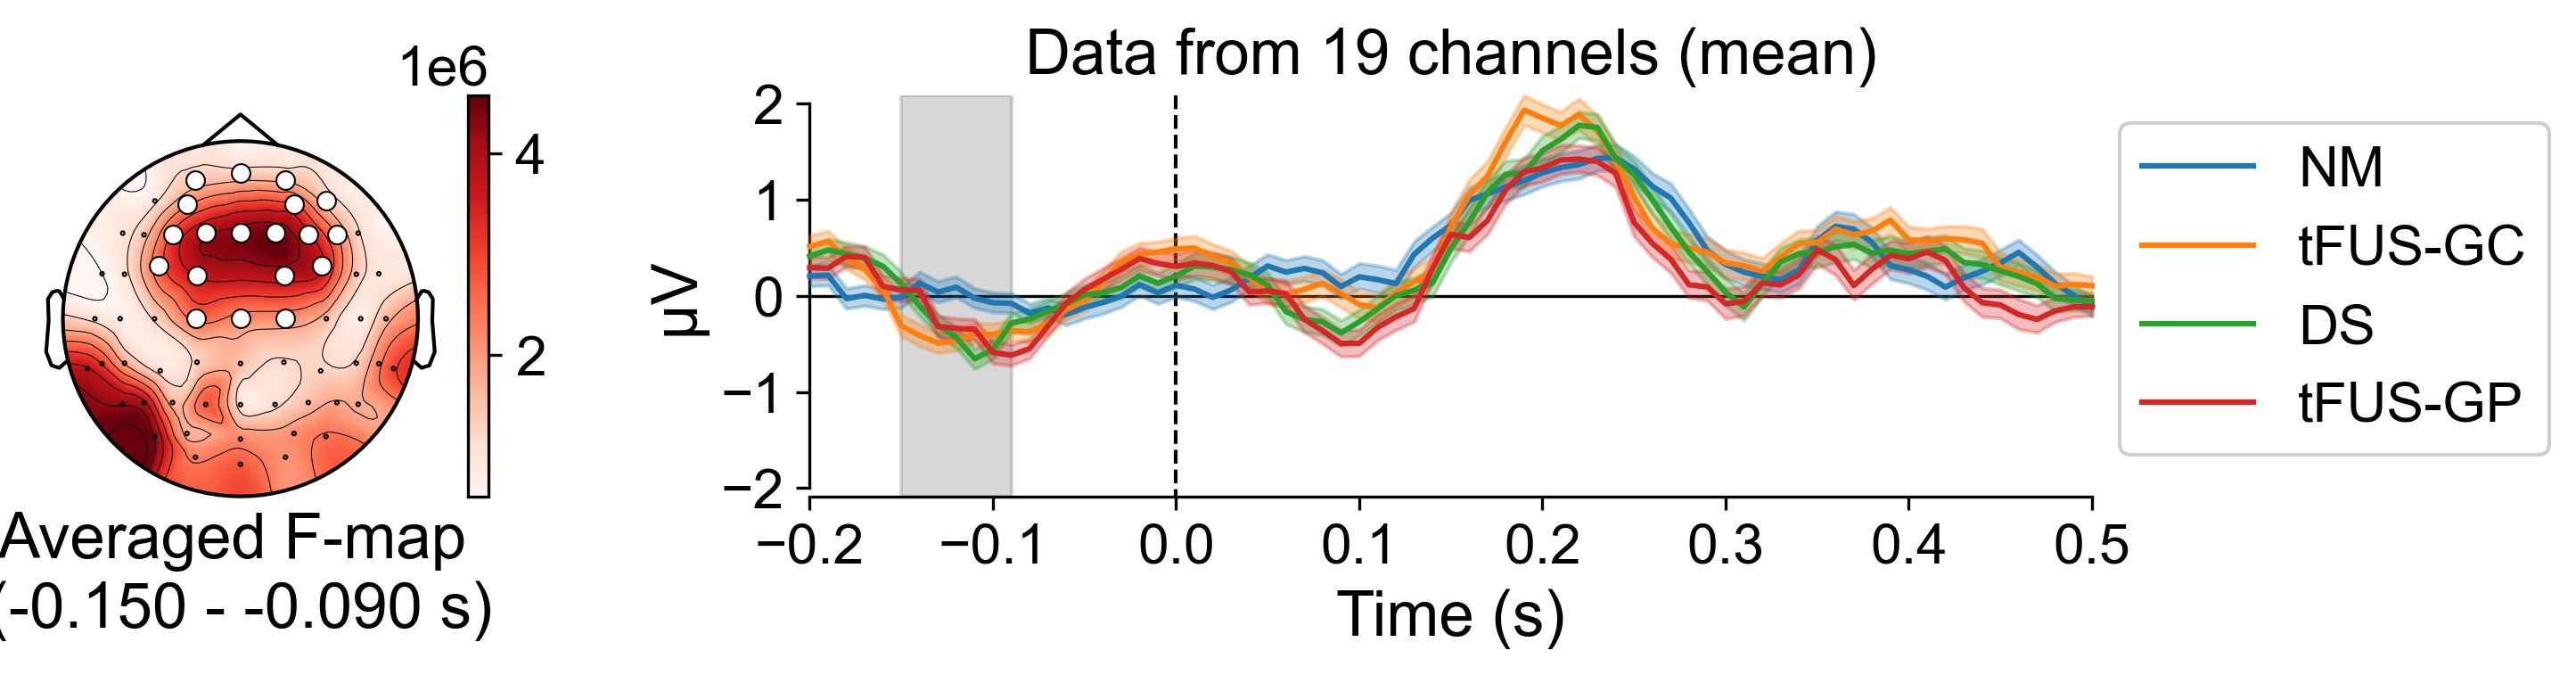

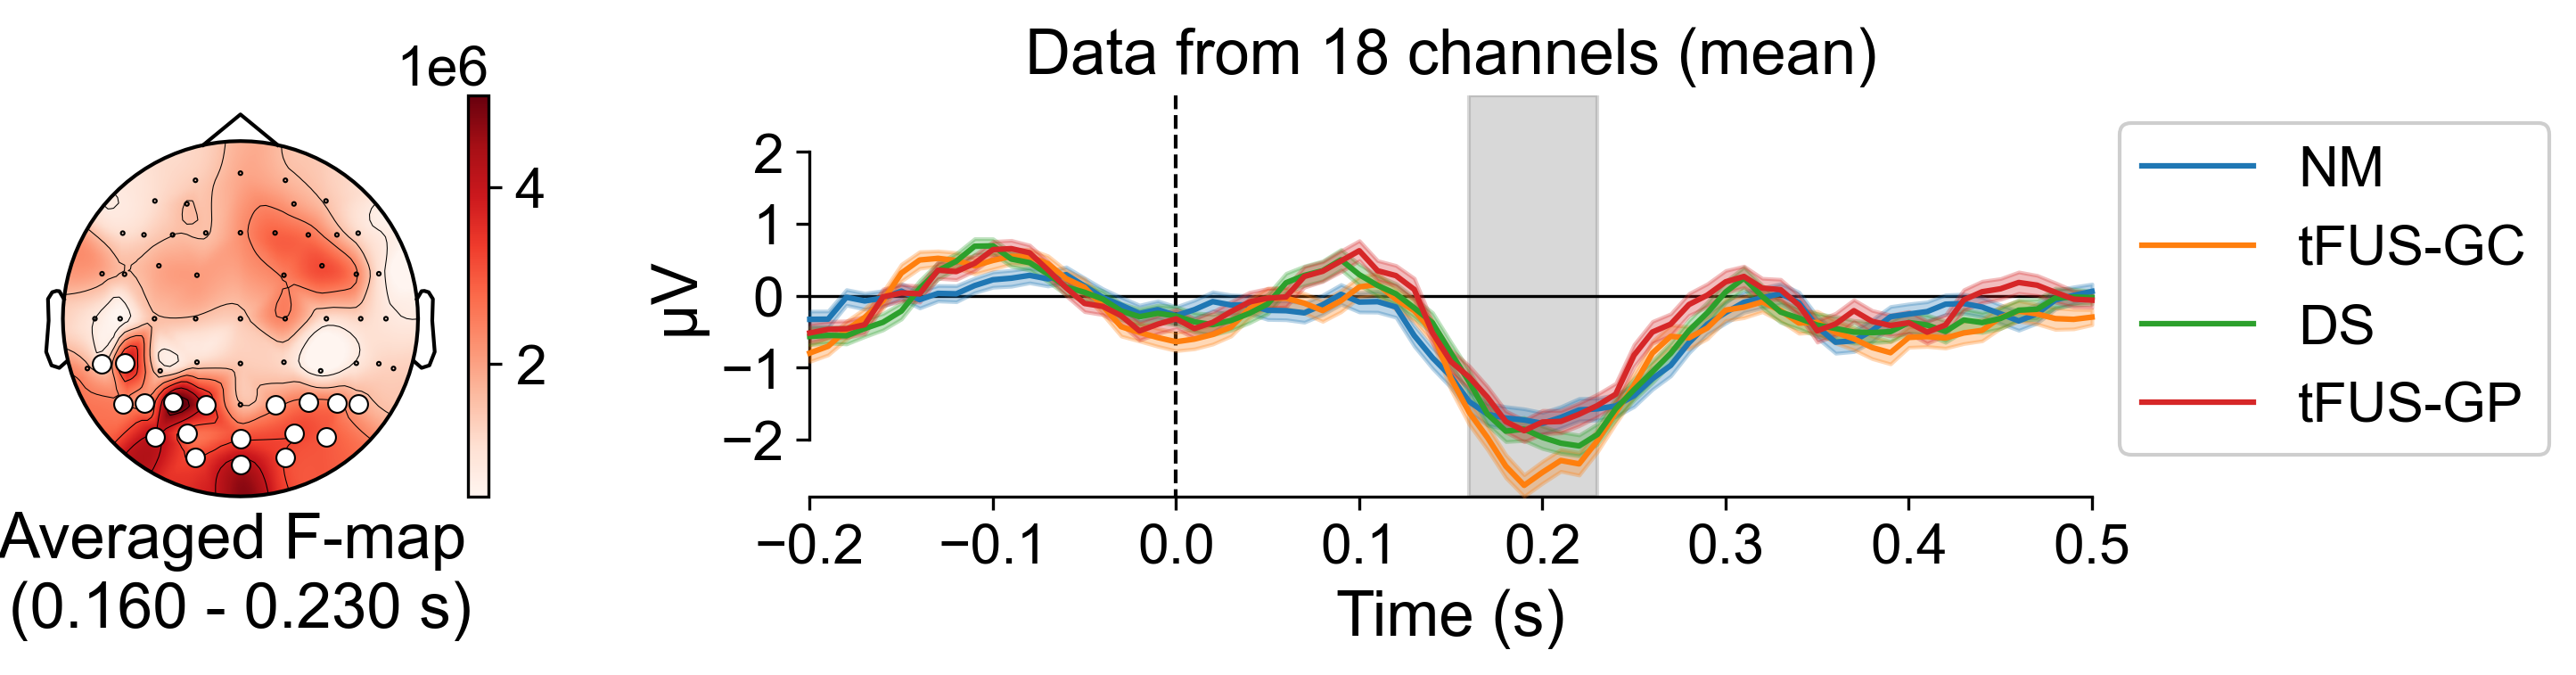

In [12]:
epoch_list = [baselines, tFUSs, shams, uscs]
mne.epochs.equalize_epoch_counts(epoch_list, method='mintime')

event_ids = ['NM', 'tFUS-GC', 'DS', 'tFUS-GP']
colors = {"tFUS-GC": "C1", "NM": "C0", 'DS': "C2", "tFUS-GP": 'C3'}


# Nice Plotting values
MEDIUM_SIZE = 15
# BIGGER_SIZE = 20
BIGGER_SIZE = 17

plt.style.use(['default'])
plt.rc('figure', dpi=300.0)
plt.rc('font', family='Arial', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=60)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Constants for the rm anova
pthresh = 0.05
return_pvals = False
factor_levels = [len(epoch_list)]
effects = "A"

def stat_fun(*args):
    # get f-values only.
    # print(args[0].shape, args[1].shape)
    
    return mne.stats.f_mway_rm(
        np.swapaxes(args, 1, 0),
        factor_levels=factor_levels,
        effects=effects,
        return_pvals=return_pvals,
    )[0]

f_thresh = mne.stats.f_threshold_mway_rm(n_subjects, factor_levels, effects, pthresh)

permutation_cluster_test(epoch_list,
                         event_ids, 
                         colors = colors,
                         alpha = pthresh, 
                         parametric=False, 
                         ci = 0.68, # 68% CI = 1 standard deviation
                         n_permutations=1000,
                         plot_combine_method = "mean", 
                         time_frequency = False, 
                         test_thresh = f_thresh,
                         # freqs = np.arange(4, 40, 1), # allll the frequencies
                         test = stat_fun,
                         scientific_notation=False,
                         n_jobs = -1,
                         save_fig = "permutation_cluster_test.svg",
                        )

In [13]:
import session_info
session_info.show()